# **Testing Aux-Net on benign tumors for the Semi-Supervised Application**
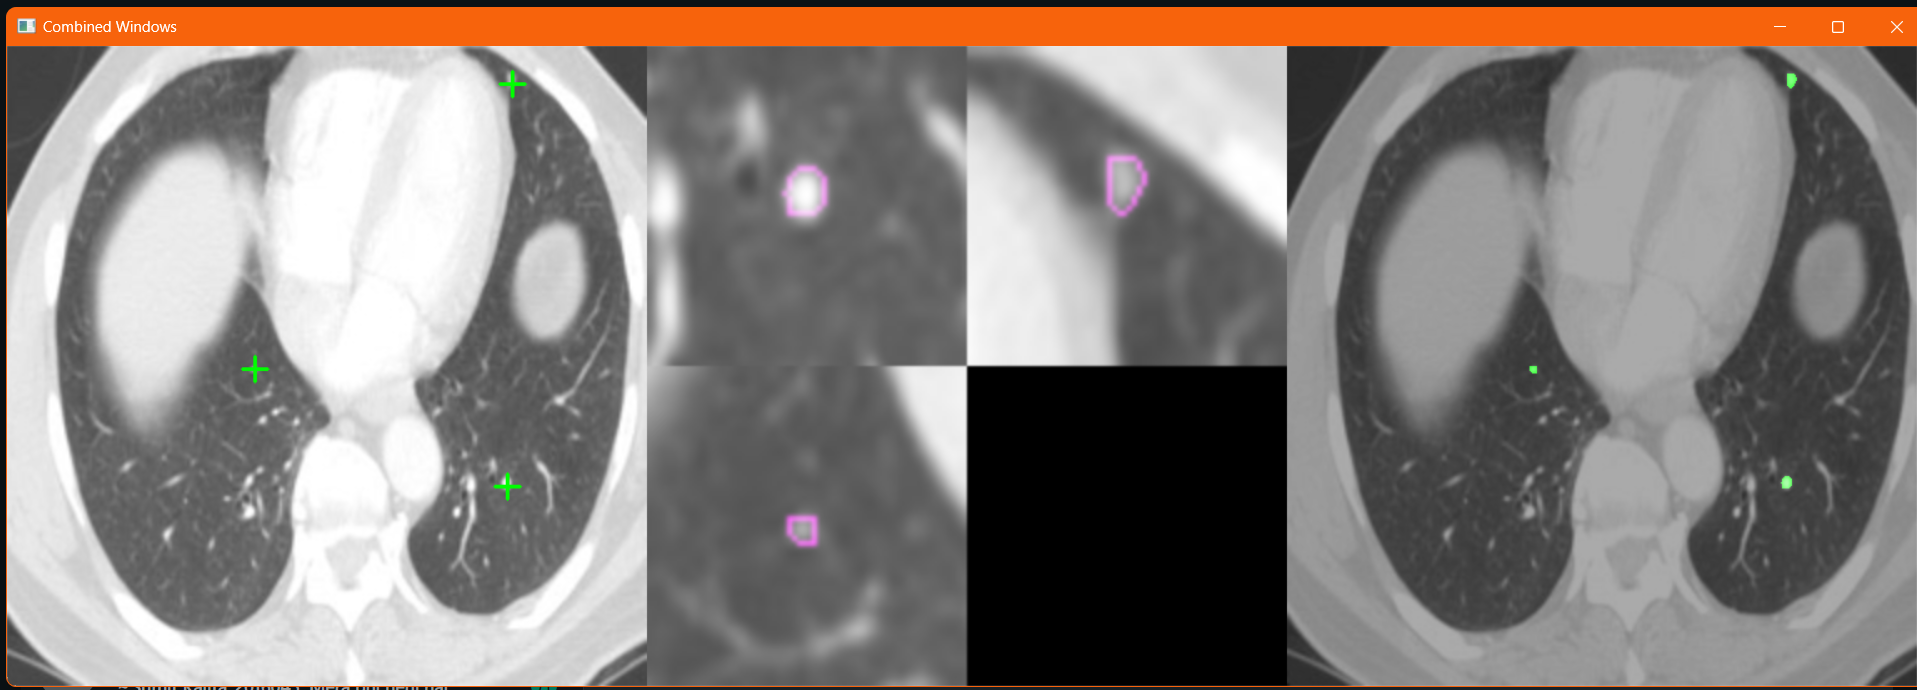
![WhatsApp Image 2024-01-06 at 01.16.51.jpeg](<attachment:WhatsApp Image 2024-01-06 at 01.16.51.jpeg>)
# Collecting Data
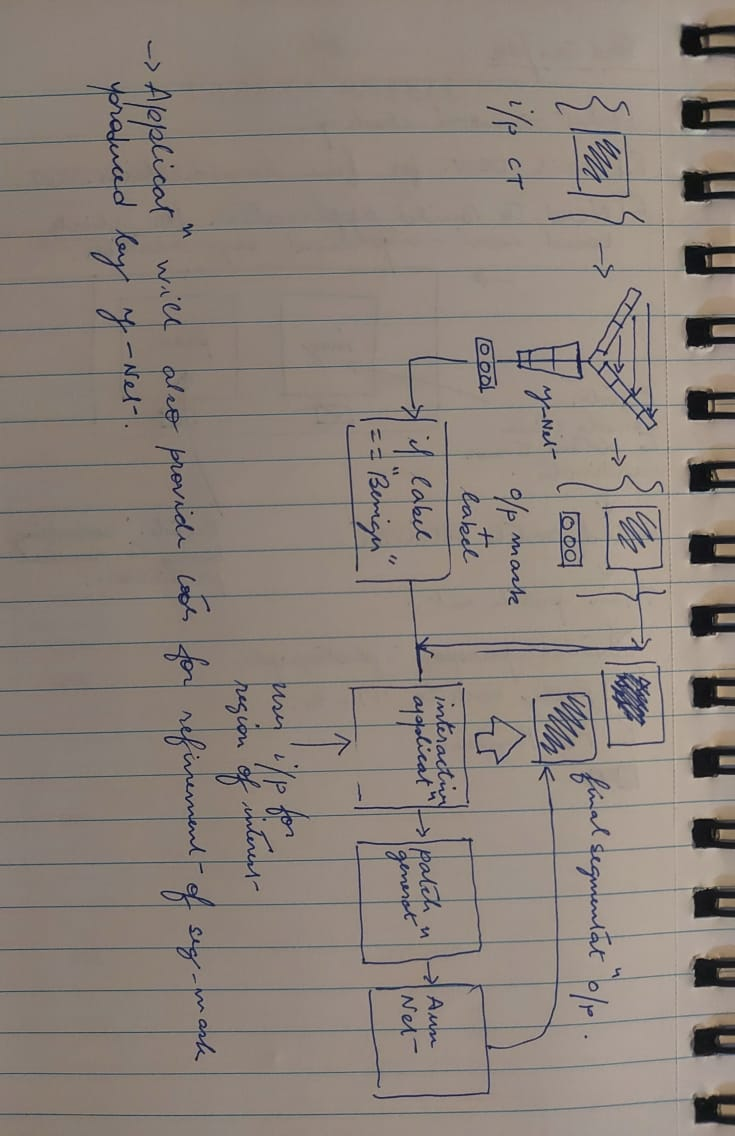

In [1]:
# This script generates a table which maps the entries in the "Balanced lung cancer dataset"...this dataset has got only two classes: [Benign, Malignant, Normal]
import os
from tqdm import tqdm
import pandas as pd
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
# Define the paths to the directories
malignant_images_path = 'E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Malignant/images_new/'
malignant_masks_path = 'E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Malignant/mask_new/'
benign_images_path = "E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_new/images/"
benign_masks_path  = "E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_new/masks/"
normal_images_path = 'E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Normal/'

# Initialize lists to store the data
data = {'Image_Path': [], 'Mask_Path': [], 'Label': []}

# Retrieve the paths and labels for the malignant images and masks
malignant_images = os.listdir(malignant_images_path)
malignant_masks = os.listdir(malignant_masks_path)

# Creates table for the malignant images and masks
for image in tqdm(malignant_images):
    image_path = os.path.join(malignant_images_path, image)
    mask_path = os.path.join(malignant_masks_path, image) if image in malignant_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(2)  # Label 1 for malignant
    
benign_images = os.listdir(benign_images_path)
benign_masks = os.listdir(benign_masks_path)

# Creates table for the benign images and masks
for image in tqdm(benign_images):
    image_path = os.path.join(benign_images_path, image)
    mask_path = os.path.join(benign_masks_path, image) if image in benign_masks else None
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(mask_path)
    data['Label'].append(1)  # Label 1 for malignant

# Creates table for the normal images
normal_images = os.listdir(normal_images_path)
for image in tqdm(normal_images):
    image_path = os.path.join(normal_images_path, image)
    data['Image_Path'].append(image_path)
    data['Mask_Path'].append(None)  # No mask for normal images
    data['Label'].append(0)  # Label 0 for normal

# Create a Pandas DataFrame from the data
df = pd.DataFrame(data)

# Display the DataFrame
#print(df.head(5))

100%|██████████| 416/416 [00:00<00:00, 108173.00it/s]


# Evaluation Metrics

In [2]:
from keras import backend as K
epsilon = 1e-5
smooth = 1e-5

def dice_coeff(y_true, y_pred, smooth=1e-5):
    y_true_flatten = K.flatten(y_true)
    y_pred_flatten = K.flatten(y_pred)
    intersection = K.sum(y_true_flatten * y_pred_flatten)
    dice = (2. * intersection + smooth) / (K.sum(y_true_flatten) + K.sum(y_pred_flatten) + smooth)
    return dice
def dice_loss(y_true, y_pred, smooth=1):
    return  1- dice_coeff(y_true, y_pred, smooth=1)

def FocalLoss(targets, inputs, alpha=0.75, gamma=2):    
    inputs = K.flatten(inputs)
    targets = K.flatten(targets)
    BCE = K.binary_crossentropy(targets, inputs)
    BCE_EXP = K.exp(-BCE)
    focal_loss = K.mean(alpha * K.pow((1-BCE_EXP), gamma) * BCE)
    return focal_loss

def total_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)
    return dice_loss(y_true, y_pred, smooth=1) + FocalLoss(y_true, y_pred, 0.25,2)
def precision(y_true, y_pred):
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1-y_true) * (1-y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1-y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())

def iou(y_true, y_pred):
    intersection = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3]) - intersection
    iou = (intersection + 1e-7) / (union + 1e-7)
    return iou

# Load Model

In [3]:
import tensorflow as tf
from tensorflow.keras.models import load_model

custom_objects = {'total_loss': total_loss,
                  'iou':iou,
                  'dice_coeff':dice_coeff,
                  'sensitivity':sensitivity,
                  'specificity':specificity
                 }

with tf.keras.utils.custom_object_scope(custom_objects):
    aux_model = load_model('E:/D/Datasets/Balanced_lung_tumor_dataset/Training_logs/aux_model_final.h5')

In [12]:
df[df["Label"]==1]["Mask_Path"][600].split("/")[-1]

'000001Resized.jpg'

In [14]:
import cv2
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Function to extract positive pixel clusters and calculate centroids
def generate_prediction(image_path, mask_path, save_folder_mask):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path is not None else None
    mask = (mask/np.max(mask) >=0.5).astype(np.uint8)

    # Find contours in the mask
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        # Calculate centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue  # Skip contours with no area
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])

        # Crop 32 by 32 patches around the centroid
        patch_size = 32
        half_patch = patch_size // 2
        if(y+half_patch>image.shape[0]):
            y_start = image.shape[0] - patch_size
            y_end = image.shape[0]
        elif(y-half_patch<0):
            y_start = 0
            y_end = patch_size
        else:
            y_start =  y - half_patch
            y_end =  y + half_patch

        if(x+half_patch>image.shape[1]):
            x_start = image.shape[1] - patch_size
            x_end = image.shape[1]
        elif(x-half_patch<0):
            x_start = 0
            x_end = patch_size
        else:
            x_start = x - half_patch
            x_end =  x + half_patch

        image_patch = image[y_start:y_end, x_start:x_end]
        image_patch = image_patch/np.max(image_patch)
        image_patch = np.expand_dims(image_patch,axis=0)
        pred = aux_model.predict(image_patch)
        pred = (pred>0.4).astype(np.uint8)*255
        pred = np.squeeze(np.squeeze(pred,axis=-1),axis=0)
    

        pred_mask = np.zeros_like(image)
        pred_mask[y_start:y_end, x_start:x_end] = pred if mask is not None else None

       
        if image_patch.size > 0:
            mask_save_path = os.path.join(save_folder_mask, image_path.split("/")[-1])
            """plt.imshow(np.hstack([image,mask*255,pred_mask*255]))
            plt.show()"""
    

            #break

            #cv2.imwrite(image_save_path, image_patch)
            cv2.imwrite(mask_save_path, pred_mask)

# Paths and directories
save_folder_mask = "E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_pred_aux_net/"


# Create directories if not exist
os.makedirs(save_folder_mask, exist_ok=True)

# Iterate through the DataFrame and process each row
for index, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row['Image_Path']
    mask_path = row['Mask_Path']
    label = row['Label']

    # Process only rows with Label == 1
    if label == 1 and mask_path is not None:
        generate_prediction(image_path, mask_path, save_folder_mask)
        


  0%|          | 0/1608 [00:00<?, ?it/s]

1/1 [==============================] - 0s 343ms/step


 37%|███▋      | 601/1608 [00:09<00:15, 66.38it/s]

1/1 [==============================] - 0s 34ms/step


 38%|███▊      | 608/1608 [00:10<00:17, 57.39it/s]

1/1 [==============================] - 0s 46ms/step


 38%|███▊      | 612/1608 [00:10<00:19, 52.24it/s]

1/1 [==============================] - 0s 35ms/step


 38%|███▊      | 614/1608 [00:11<00:20, 49.23it/s]

1/1 [==============================] - 0s 64ms/step


 38%|███▊      | 616/1608 [00:11<00:21, 46.02it/s]

1/1 [==============================] - 0s 37ms/step


 38%|███▊      | 618/1608 [00:11<00:23, 41.72it/s]

1/1 [==============================] - 0s 45ms/step


 39%|███▊      | 620/1608 [00:11<00:26, 37.84it/s]

1/1 [==============================] - 0s 50ms/step


 39%|███▊      | 621/1608 [00:11<00:28, 34.79it/s]

1/1 [==============================] - 0s 47ms/step


 39%|███▊      | 622/1608 [00:12<00:31, 31.22it/s]

1/1 [==============================] - 0s 53ms/step


 39%|███▊      | 623/1608 [00:12<00:35, 27.52it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 624/1608 [00:12<00:47, 20.68it/s]

1/1 [==============================] - 0s 36ms/step


 39%|███▉      | 625/1608 [00:13<01:20, 12.18it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 626/1608 [00:13<01:37, 10.04it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 627/1608 [00:13<02:02,  8.01it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 628/1608 [00:14<02:13,  7.33it/s]

1/1 [==============================] - 0s 32ms/step


 39%|███▉      | 629/1608 [00:14<02:29,  6.55it/s]

1/1 [==============================] - 0s 40ms/step


 39%|███▉      | 630/1608 [00:14<02:23,  6.79it/s]

1/1 [==============================] - 0s 39ms/step


 39%|███▉      | 631/1608 [00:14<02:24,  6.77it/s]

1/1 [==============================] - 0s 34ms/step


 39%|███▉      | 632/1608 [00:14<02:24,  6.75it/s]

1/1 [==============================] - 0s 48ms/step


 39%|███▉      | 633/1608 [00:14<02:38,  6.13it/s]

1/1 [==============================] - 0s 33ms/step


 39%|███▉      | 634/1608 [00:14<02:24,  6.76it/s]

1/1 [==============================] - 0s 43ms/step


 39%|███▉      | 635/1608 [00:15<02:12,  7.37it/s]

1/1 [==============================] - 0s 42ms/step


 40%|███▉      | 636/1608 [00:15<02:08,  7.56it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 637/1608 [00:15<02:09,  7.49it/s]

1/1 [==============================] - 0s 37ms/step


 40%|███▉      | 638/1608 [00:15<02:06,  7.66it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 639/1608 [00:15<02:04,  7.77it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 640/1608 [00:15<02:01,  8.00it/s]

1/1 [==============================] - 0s 38ms/step


 40%|███▉      | 641/1608 [00:15<02:03,  7.85it/s]

1/1 [==============================] - 0s 32ms/step


 40%|███▉      | 642/1608 [00:15<02:06,  7.65it/s]

1/1 [==============================] - 0s 40ms/step


 40%|███▉      | 643/1608 [00:16<03:06,  5.17it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 644/1608 [00:16<04:05,  3.93it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 645/1608 [00:17<04:45,  3.37it/s]

1/1 [==============================] - 0s 40ms/step


 40%|████      | 646/1608 [00:17<04:57,  3.23it/s]

1/1 [==============================] - 0s 45ms/step


 40%|████      | 647/1608 [00:17<05:06,  3.13it/s]

1/1 [==============================] - 0s 33ms/step


 40%|████      | 648/1608 [00:18<05:14,  3.05it/s]

1/1 [==============================] - 0s 49ms/step


 40%|████      | 649/1608 [00:18<04:25,  3.61it/s]

1/1 [==============================] - 0s 30ms/step


 40%|████      | 650/1608 [00:18<03:54,  4.08it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 652/1608 [00:18<02:50,  5.60it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 653/1608 [00:18<02:32,  6.28it/s]

1/1 [==============================] - 0s 37ms/step


 41%|████      | 654/1608 [00:18<02:19,  6.82it/s]

1/1 [==============================] - 0s 40ms/step


 41%|████      | 655/1608 [00:19<02:09,  7.35it/s]

1/1 [==============================] - 0s 38ms/step


 41%|████      | 656/1608 [00:19<02:03,  7.70it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 657/1608 [00:19<01:59,  7.95it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 658/1608 [00:19<01:57,  8.12it/s]

1/1 [==============================] - 0s 23ms/step


 41%|████      | 659/1608 [00:19<01:54,  8.30it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 660/1608 [00:19<02:00,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████      | 661/1608 [00:19<02:24,  6.55it/s]

1/1 [==============================] - 0s 32ms/step


 41%|████      | 662/1608 [00:20<02:44,  5.74it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████      | 663/1608 [00:20<02:45,  5.70it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 664/1608 [00:20<02:41,  5.84it/s]

1/1 [==============================] - 0s 31ms/step


 41%|████▏     | 665/1608 [00:20<02:41,  5.83it/s]

1/1 [==============================] - 0s 27ms/step


 41%|████▏     | 666/1608 [00:20<02:37,  5.96it/s]

1/1 [==============================] - 0s 29ms/step


 41%|████▏     | 667/1608 [00:20<02:29,  6.29it/s]

1/1 [==============================] - 0s 37ms/step


 42%|████▏     | 669/1608 [00:21<01:57,  7.98it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 671/1608 [00:21<01:42,  9.16it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 673/1608 [00:21<01:35,  9.76it/s]

1/1 [==============================] - 0s 32ms/step


 42%|████▏     | 675/1608 [00:21<01:25, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 42%|████▏     | 677/1608 [00:21<01:20, 11.59it/s]

1/1 [==============================] - 0s 27ms/step


 42%|████▏     | 679/1608 [00:21<01:28, 10.45it/s]

1/1 [==============================] - 0s 24ms/step


 42%|████▏     | 681/1608 [00:22<01:56,  7.95it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 682/1608 [00:22<02:02,  7.57it/s]

1/1 [==============================] - 0s 33ms/step


 42%|████▏     | 683/1608 [00:22<02:13,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 43%|████▎     | 684/1608 [00:22<02:17,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 43%|████▎     | 686/1608 [00:22<01:52,  8.19it/s]

1/1 [==============================] - 0s 20ms/step


 43%|████▎     | 688/1608 [00:23<01:39,  9.25it/s]

1/1 [==============================] - 0s 25ms/step


 43%|████▎     | 690/1608 [00:23<01:31, 10.03it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 692/1608 [00:23<01:28, 10.33it/s]

1/1 [==============================] - 0s 32ms/step


 43%|████▎     | 694/1608 [00:23<01:25, 10.66it/s]

1/1 [==============================] - 0s 27ms/step


 43%|████▎     | 696/1608 [00:23<01:22, 11.03it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 698/1608 [00:24<01:23, 10.84it/s]

1/1 [==============================] - 0s 24ms/step


 44%|████▎     | 700/1608 [00:24<01:25, 10.60it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▎     | 702/1608 [00:24<01:25, 10.61it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 704/1608 [00:24<01:21, 11.16it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▍     | 706/1608 [00:24<01:41,  8.89it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 707/1608 [00:25<01:44,  8.65it/s]

1/1 [==============================] - 0s 38ms/step


 44%|████▍     | 708/1608 [00:25<01:49,  8.19it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 709/1608 [00:25<01:45,  8.50it/s]

1/1 [==============================] - 0s 23ms/step


 44%|████▍     | 711/1608 [00:25<01:32,  9.67it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 712/1608 [00:25<01:33,  9.57it/s]

1/1 [==============================] - 0s 32ms/step


 44%|████▍     | 714/1608 [00:25<01:30,  9.91it/s]

1/1 [==============================] - 0s 33ms/step


 44%|████▍     | 715/1608 [00:25<01:30,  9.82it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 717/1608 [00:26<01:29, 10.00it/s]

1/1 [==============================] - 0s 46ms/step


 45%|████▍     | 718/1608 [00:26<01:30,  9.78it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 720/1608 [00:26<01:23, 10.70it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▍     | 722/1608 [00:26<01:50,  8.05it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 723/1608 [00:26<01:58,  7.47it/s]

1/1 [==============================] - 0s 28ms/step


 45%|████▌     | 724/1608 [00:27<02:07,  6.92it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 725/1608 [00:27<02:21,  6.23it/s]

1/1 [==============================] - 0s 31ms/step


 45%|████▌     | 726/1608 [00:27<02:35,  5.67it/s]

1/1 [==============================] - 0s 27ms/step


 45%|████▌     | 727/1608 [00:27<02:21,  6.21it/s]

1/1 [==============================] - 0s 32ms/step


 45%|████▌     | 728/1608 [00:27<02:12,  6.64it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 729/1608 [00:27<02:05,  7.02it/s]

1/1 [==============================] - 0s 36ms/step


 45%|████▌     | 730/1608 [00:27<01:54,  7.66it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 732/1608 [00:28<01:37,  8.97it/s]

1/1 [==============================] - 0s 87ms/step


 46%|████▌     | 733/1608 [00:28<01:45,  8.25it/s]

1/1 [==============================] - 0s 30ms/step


 46%|████▌     | 734/1608 [00:28<01:44,  8.40it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 736/1608 [00:28<01:27,  9.93it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 737/1608 [00:28<01:29,  9.69it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 738/1608 [00:28<01:39,  8.74it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 739/1608 [00:28<01:47,  8.05it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 740/1608 [00:29<01:56,  7.45it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 741/1608 [00:29<02:06,  6.87it/s]

1/1 [==============================] - 0s 40ms/step


 46%|████▌     | 742/1608 [00:29<02:08,  6.76it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 743/1608 [00:29<02:11,  6.60it/s]

1/1 [==============================] - 0s 34ms/step


 46%|████▋     | 744/1608 [00:29<02:17,  6.30it/s]

1/1 [==============================] - 0s 39ms/step


 46%|████▋     | 745/1608 [00:29<02:06,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


 46%|████▋     | 747/1608 [00:30<01:36,  8.94it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 748/1608 [00:30<01:34,  9.10it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 750/1608 [00:30<01:33,  9.21it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 752/1608 [00:30<01:25, 10.01it/s]

1/1 [==============================] - 0s 42ms/step


 47%|████▋     | 754/1608 [00:30<01:32,  9.20it/s]

1/1 [==============================] - 0s 23ms/step


 47%|████▋     | 756/1608 [00:30<01:23, 10.17it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 758/1608 [00:31<01:15, 11.23it/s]

1/1 [==============================] - 0s 20ms/step


 47%|████▋     | 760/1608 [00:31<01:17, 10.96it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 762/1608 [00:31<01:17, 10.98it/s]

1/1 [==============================] - 0s 20ms/step


 48%|████▊     | 764/1608 [00:31<01:11, 11.77it/s]

1/1 [==============================] - 0s 33ms/step


 48%|████▊     | 766/1608 [00:31<01:09, 12.07it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 768/1608 [00:31<01:14, 11.30it/s]

1/1 [==============================] - 0s 21ms/step


 48%|████▊     | 770/1608 [00:32<01:20, 10.37it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 772/1608 [00:32<01:15, 11.04it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 774/1608 [00:32<01:15, 11.03it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 776/1608 [00:32<01:11, 11.65it/s]

1/1 [==============================] - 0s 18ms/step


 48%|████▊     | 778/1608 [00:32<01:07, 12.24it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 780/1608 [00:32<01:06, 12.45it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▊     | 782/1608 [00:33<01:06, 12.42it/s]

1/1 [==============================] - 0s 29ms/step


 49%|████▉     | 784/1608 [00:33<01:09, 11.92it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 786/1608 [00:33<01:11, 11.48it/s]

1/1 [==============================] - 0s 17ms/step


 49%|████▉     | 788/1608 [00:33<01:08, 12.02it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 790/1608 [00:33<01:06, 12.36it/s]

1/1 [==============================] - 0s 31ms/step


 49%|████▉     | 792/1608 [00:33<01:09, 11.68it/s]

1/1 [==============================] - 0s 19ms/step


 49%|████▉     | 794/1608 [00:34<01:05, 12.42it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 796/1608 [00:34<01:07, 11.95it/s]

1/1 [==============================] - 0s 46ms/step


 50%|████▉     | 798/1608 [00:34<01:33,  8.63it/s]

1/1 [==============================] - 0s 34ms/step


 50%|████▉     | 800/1608 [00:34<01:25,  9.40it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 802/1608 [00:35<01:22,  9.80it/s]

1/1 [==============================] - 0s 23ms/step


 50%|█████     | 804/1608 [00:35<01:15, 10.58it/s]

1/1 [==============================] - 0s 33ms/step


 50%|█████     | 806/1608 [00:35<01:19, 10.10it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 808/1608 [00:35<01:14, 10.71it/s]

1/1 [==============================] - 0s 26ms/step


 50%|█████     | 810/1608 [00:36<02:11,  6.08it/s]

1/1 [==============================] - 0s 43ms/step


 50%|█████     | 812/1608 [00:36<01:55,  6.90it/s]

1/1 [==============================] - 0s 49ms/step


 51%|█████     | 814/1608 [00:36<01:43,  7.64it/s]

1/1 [==============================] - 0s 20ms/step


 51%|█████     | 816/1608 [00:36<01:33,  8.45it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 818/1608 [00:36<01:25,  9.21it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 820/1608 [00:37<01:19,  9.97it/s]

1/1 [==============================] - 0s 18ms/step


 51%|█████     | 822/1608 [00:37<01:26,  9.07it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 824/1608 [00:37<01:19,  9.88it/s]

1/1 [==============================] - 0s 32ms/step


 51%|█████▏    | 826/1608 [00:37<01:17, 10.04it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████▏    | 828/1608 [00:37<01:15, 10.40it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 830/1608 [00:38<01:11, 10.82it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 832/1608 [00:38<01:09, 11.12it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 834/1608 [00:38<01:19,  9.71it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 836/1608 [00:38<01:17,  9.91it/s]

1/1 [==============================] - 0s 33ms/step


 52%|█████▏    | 838/1608 [00:38<01:16, 10.07it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 840/1608 [00:39<01:16, 10.00it/s]

1/1 [==============================] - 0s 28ms/step


 52%|█████▏    | 842/1608 [00:39<01:13, 10.44it/s]

1/1 [==============================] - 0s 30ms/step


 52%|█████▏    | 844/1608 [00:39<01:19,  9.65it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 845/1608 [00:39<01:20,  9.42it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 847/1608 [00:39<01:20,  9.41it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 849/1608 [00:40<01:16,  9.89it/s]

1/1 [==============================] - 0s 41ms/step


 53%|█████▎    | 851/1608 [00:40<01:13, 10.31it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 853/1608 [00:40<01:07, 11.18it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 855/1608 [00:40<01:03, 11.80it/s]

1/1 [==============================] - 0s 20ms/step


 53%|█████▎    | 857/1608 [00:40<01:10, 10.63it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 859/1608 [00:40<01:07, 11.18it/s]

1/1 [==============================] - 0s 32ms/step


 54%|█████▎    | 861/1608 [00:41<01:09, 10.82it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▎    | 863/1608 [00:41<01:06, 11.24it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 865/1608 [00:41<01:17,  9.65it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 867/1608 [00:41<01:32,  7.97it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 868/1608 [00:42<01:41,  7.26it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 869/1608 [00:42<01:45,  7.02it/s]

1/1 [==============================] - 0s 34ms/step


 54%|█████▍    | 870/1608 [00:42<01:49,  6.75it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 872/1608 [00:42<01:32,  7.94it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▍    | 874/1608 [00:42<01:34,  7.77it/s]

1/1 [==============================] - 0s 43ms/step


 54%|█████▍    | 875/1608 [00:42<01:31,  7.98it/s]

1/1 [==============================] - 0s 33ms/step


 54%|█████▍    | 876/1608 [00:43<01:43,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 878/1608 [00:43<01:24,  8.61it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 879/1608 [00:43<01:27,  8.35it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▍    | 880/1608 [00:43<01:30,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 881/1608 [00:43<01:44,  6.94it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 883/1608 [00:43<01:27,  8.28it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 884/1608 [00:44<01:24,  8.58it/s]

1/1 [==============================] - 0s 25ms/step


 55%|█████▌    | 886/1608 [00:44<01:10, 10.28it/s]

1/1 [==============================] - 0s 28ms/step


 55%|█████▌    | 888/1608 [00:44<01:16,  9.39it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 890/1608 [00:44<01:11, 10.00it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 892/1608 [00:44<01:07, 10.63it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 894/1608 [00:44<01:10, 10.15it/s]

1/1 [==============================] - 0s 21ms/step


 56%|█████▌    | 896/1608 [00:45<01:12,  9.83it/s]

1/1 [==============================] - 0s 27ms/step


 56%|█████▌    | 898/1608 [00:45<01:16,  9.26it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 899/1608 [00:45<01:18,  9.00it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 901/1608 [00:45<01:13,  9.59it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▌    | 903/1608 [00:45<01:10, 10.03it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▋    | 905/1608 [00:46<01:06, 10.52it/s]

1/1 [==============================] - 0s 32ms/step


 56%|█████▋    | 907/1608 [00:46<01:09, 10.13it/s]

1/1 [==============================] - 0s 31ms/step


 57%|█████▋    | 909/1608 [00:46<01:12,  9.59it/s]

1/1 [==============================] - 0s 38ms/step


 57%|█████▋    | 910/1608 [00:46<01:12,  9.65it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 911/1608 [00:46<01:13,  9.51it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 912/1608 [00:46<01:15,  9.21it/s]

1/1 [==============================] - 0s 45ms/step


 57%|█████▋    | 913/1608 [00:47<01:19,  8.79it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 914/1608 [00:47<01:19,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 915/1608 [00:47<01:17,  8.93it/s]

1/1 [==============================] - 0s 49ms/step


 57%|█████▋    | 916/1608 [00:47<01:20,  8.55it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 917/1608 [00:47<01:18,  8.81it/s]

1/1 [==============================] - 0s 39ms/step


 57%|█████▋    | 918/1608 [00:47<01:34,  7.33it/s]

1/1 [==============================] - 0s 35ms/step


 57%|█████▋    | 920/1608 [00:47<01:20,  8.57it/s]

1/1 [==============================] - 0s 44ms/step


 57%|█████▋    | 922/1608 [00:48<01:16,  8.94it/s]

1/1 [==============================] - 0s 41ms/step


 57%|█████▋    | 923/1608 [00:48<01:17,  8.85it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 924/1608 [00:48<01:18,  8.72it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 925/1608 [00:48<01:17,  8.83it/s]

1/1 [==============================] - 0s 44ms/step


 58%|█████▊    | 926/1608 [00:48<01:23,  8.21it/s]

1/1 [==============================] - 0s 28ms/step


 58%|█████▊    | 927/1608 [00:48<01:40,  6.79it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 928/1608 [00:48<01:35,  7.15it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 929/1608 [00:49<01:32,  7.34it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 930/1608 [00:49<01:29,  7.56it/s]

1/1 [==============================] - 0s 37ms/step


 58%|█████▊    | 931/1608 [00:49<01:29,  7.59it/s]

1/1 [==============================] - 0s 39ms/step


 58%|█████▊    | 932/1608 [00:49<01:25,  7.88it/s]

1/1 [==============================] - 0s 55ms/step


 58%|█████▊    | 933/1608 [00:49<01:31,  7.38it/s]

1/1 [==============================] - 0s 43ms/step


 58%|█████▊    | 934/1608 [00:49<01:28,  7.62it/s]

1/1 [==============================] - 0s 33ms/step


 58%|█████▊    | 936/1608 [00:49<01:25,  7.82it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 937/1608 [00:50<01:21,  8.20it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 938/1608 [00:50<01:19,  8.38it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 939/1608 [00:50<01:18,  8.57it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 940/1608 [00:50<01:17,  8.57it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▊    | 941/1608 [00:50<01:21,  8.21it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▊    | 943/1608 [00:50<01:11,  9.33it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 945/1608 [00:50<01:07,  9.83it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 946/1608 [00:51<01:19,  8.38it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 948/1608 [00:51<01:12,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 949/1608 [00:51<01:11,  9.21it/s]

1/1 [==============================] - 0s 30ms/step


 59%|█████▉    | 950/1608 [00:51<01:10,  9.37it/s]

1/1 [==============================] - 0s 33ms/step


 59%|█████▉    | 951/1608 [00:51<01:15,  8.76it/s]

1/1 [==============================] - 0s 19ms/step


 59%|█████▉    | 953/1608 [00:51<01:08,  9.62it/s]

1/1 [==============================] - 0s 37ms/step


 59%|█████▉    | 954/1608 [00:51<01:09,  9.43it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 955/1608 [00:51<01:11,  9.11it/s]

1/1 [==============================] - 0s 43ms/step


 59%|█████▉    | 956/1608 [00:52<01:23,  7.78it/s]

1/1 [==============================] - 0s 22ms/step


 60%|█████▉    | 958/1608 [00:52<01:13,  8.82it/s]

1/1 [==============================] - 0s 42ms/step


 60%|█████▉    | 959/1608 [00:52<01:13,  8.84it/s]

1/1 [==============================] - 0s 43ms/step


 60%|█████▉    | 960/1608 [00:52<01:22,  7.84it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 961/1608 [00:52<01:17,  8.32it/s]

1/1 [==============================] - 0s 32ms/step


 60%|█████▉    | 963/1608 [00:52<01:11,  8.99it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 965/1608 [00:53<01:06,  9.66it/s]

1/1 [==============================] - 0s 46ms/step


 60%|██████    | 966/1608 [00:53<01:20,  8.02it/s]

1/1 [==============================] - 0s 40ms/step


 60%|██████    | 967/1608 [00:53<01:17,  8.30it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 969/1608 [00:53<01:10,  9.04it/s]

1/1 [==============================] - 0s 32ms/step


 60%|██████    | 971/1608 [00:53<01:04,  9.86it/s]

1/1 [==============================] - 0s 58ms/step


 60%|██████    | 972/1608 [00:53<01:07,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 973/1608 [00:54<01:06,  9.54it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 975/1608 [00:54<01:08,  9.29it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 976/1608 [00:54<01:21,  7.75it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 977/1608 [00:54<01:20,  7.79it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 978/1608 [00:54<01:23,  7.56it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 979/1608 [00:54<01:18,  8.06it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 981/1608 [00:54<01:07,  9.32it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████    | 983/1608 [00:55<01:00, 10.32it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████▏   | 985/1608 [00:55<00:58, 10.57it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 987/1608 [00:55<01:04,  9.66it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 989/1608 [00:55<01:05,  9.52it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 990/1608 [00:55<01:05,  9.49it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 992/1608 [00:56<00:59, 10.31it/s]

1/1 [==============================] - 0s 42ms/step


 62%|██████▏   | 994/1608 [00:56<00:59, 10.36it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 996/1608 [00:56<01:02,  9.87it/s]

1/1 [==============================] - 0s 48ms/step


 62%|██████▏   | 997/1608 [00:56<01:14,  8.19it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 999/1608 [00:56<01:04,  9.40it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▏   | 1001/1608 [00:56<01:00,  9.96it/s]

1/1 [==============================] - 0s 23ms/step


 62%|██████▏   | 1003/1608 [00:57<00:56, 10.65it/s]

1/1 [==============================] - 0s 24ms/step


 62%|██████▎   | 1005/1608 [00:57<00:52, 11.39it/s]

1/1 [==============================] - 0s 20ms/step


 63%|██████▎   | 1007/1608 [00:57<00:50, 11.92it/s]

1/1 [==============================] - 0s 22ms/step


 63%|██████▎   | 1009/1608 [00:57<00:51, 11.65it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1011/1608 [00:57<00:58, 10.23it/s]

1/1 [==============================] - 0s 41ms/step


 63%|██████▎   | 1013/1608 [00:58<00:55, 10.67it/s]

1/1 [==============================] - 0s 21ms/step


 63%|██████▎   | 1015/1608 [00:58<00:52, 11.35it/s]

1/1 [==============================] - 0s 36ms/step


 63%|██████▎   | 1017/1608 [00:58<00:54, 10.93it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1019/1608 [00:58<00:52, 11.16it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1021/1608 [00:58<00:51, 11.43it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 1023/1608 [00:59<00:59,  9.79it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████▎   | 1025/1608 [00:59<01:11,  8.15it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1026/1608 [00:59<01:13,  7.91it/s]

1/1 [==============================] - 0s 42ms/step


 64%|██████▍   | 1027/1608 [00:59<01:11,  8.09it/s]

1/1 [==============================] - 0s 46ms/step


 64%|██████▍   | 1028/1608 [00:59<01:12,  8.05it/s]

1/1 [==============================] - 0s 40ms/step


 64%|██████▍   | 1029/1608 [00:59<01:12,  7.96it/s]

1/1 [==============================] - 0s 38ms/step


 64%|██████▍   | 1030/1608 [01:00<01:27,  6.63it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1031/1608 [01:00<01:23,  6.91it/s]

1/1 [==============================] - 0s 43ms/step


 64%|██████▍   | 1032/1608 [01:00<01:18,  7.30it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1033/1608 [01:00<01:13,  7.78it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1034/1608 [01:00<01:11,  7.98it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1036/1608 [01:00<01:02,  9.12it/s]

1/1 [==============================] - 0s 44ms/step


 65%|██████▍   | 1038/1608 [01:00<00:59,  9.59it/s]

1/1 [==============================] - 0s 37ms/step


 65%|██████▍   | 1039/1608 [01:01<01:00,  9.47it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▍   | 1040/1608 [01:01<01:07,  8.44it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1042/1608 [01:01<00:58,  9.75it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▍   | 1043/1608 [01:01<01:11,  7.87it/s]

1/1 [==============================] - 0s 26ms/step


 65%|██████▍   | 1044/1608 [01:01<01:24,  6.64it/s]

1/1 [==============================] - 0s 22ms/step


 65%|██████▍   | 1045/1608 [01:01<01:25,  6.60it/s]

1/1 [==============================] - 0s 53ms/step


 65%|██████▌   | 1046/1608 [01:02<01:33,  6.01it/s]

1/1 [==============================] - 0s 42ms/step


 65%|██████▌   | 1047/1608 [01:02<01:52,  4.98it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 1048/1608 [01:02<01:49,  5.13it/s]

1/1 [==============================] - 0s 30ms/step


 65%|██████▌   | 1050/1608 [01:02<01:21,  6.85it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▌   | 1052/1608 [01:02<01:06,  8.32it/s]

1/1 [==============================] - 0s 37ms/step


 66%|██████▌   | 1054/1608 [01:03<01:00,  9.12it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1056/1608 [01:03<00:55,  9.86it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1058/1608 [01:03<00:54, 10.13it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1060/1608 [01:03<00:50, 10.85it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▌   | 1062/1608 [01:03<00:49, 11.00it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1064/1608 [01:03<00:46, 11.78it/s]

1/1 [==============================] - 0s 22ms/step


 66%|██████▋   | 1066/1608 [01:04<00:46, 11.77it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▋   | 1068/1608 [01:04<01:09,  7.76it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 1069/1608 [01:04<01:16,  7.04it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1070/1608 [01:04<01:20,  6.67it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1071/1608 [01:05<01:26,  6.21it/s]

1/1 [==============================] - 0s 34ms/step


 67%|██████▋   | 1072/1608 [01:05<01:30,  5.95it/s]

1/1 [==============================] - 0s 21ms/step


 67%|██████▋   | 1073/1608 [01:05<01:20,  6.62it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1074/1608 [01:05<01:23,  6.40it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1076/1608 [01:05<01:06,  7.97it/s]

1/1 [==============================] - 0s 36ms/step


 67%|██████▋   | 1077/1608 [01:05<01:09,  7.63it/s]

1/1 [==============================] - 0s 23ms/step


 67%|██████▋   | 1079/1608 [01:06<00:59,  8.82it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1081/1608 [01:06<00:50, 10.36it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1083/1608 [01:06<00:46, 11.18it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1085/1608 [01:06<00:47, 10.96it/s]

1/1 [==============================] - 0s 22ms/step


 68%|██████▊   | 1087/1608 [01:06<00:54,  9.55it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1089/1608 [01:07<00:54,  9.50it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 1090/1608 [01:07<00:57,  8.98it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1091/1608 [01:07<00:56,  9.15it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1092/1608 [01:07<00:56,  9.09it/s]

1/1 [==============================] - 0s 37ms/step


 68%|██████▊   | 1093/1608 [01:07<00:56,  9.16it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1095/1608 [01:07<00:51,  9.89it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1096/1608 [01:07<01:00,  8.52it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1098/1608 [01:08<00:54,  9.36it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1100/1608 [01:08<00:49, 10.29it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 1102/1608 [01:08<00:48, 10.53it/s]

1/1 [==============================] - 0s 35ms/step


 69%|██████▊   | 1104/1608 [01:08<00:51,  9.78it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 1105/1608 [01:08<00:53,  9.46it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1107/1608 [01:08<00:52,  9.48it/s]

1/1 [==============================] - 0s 16ms/step


 69%|██████▉   | 1109/1608 [01:09<01:07,  7.34it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 1110/1608 [01:09<01:27,  5.69it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1111/1608 [01:10<01:54,  4.33it/s]

1/1 [==============================] - 0s 43ms/step


 69%|██████▉   | 1112/1608 [01:10<02:13,  3.72it/s]

1/1 [==============================] - 0s 30ms/step


 69%|██████▉   | 1113/1608 [01:10<02:23,  3.45it/s]

1/1 [==============================] - 0s 47ms/step


 69%|██████▉   | 1114/1608 [01:11<02:50,  2.90it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1116/1608 [01:11<01:54,  4.29it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▉   | 1117/1608 [01:11<01:40,  4.91it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1118/1608 [01:11<01:27,  5.58it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1120/1608 [01:11<01:10,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1121/1608 [01:12<01:07,  7.24it/s]

1/1 [==============================] - 0s 40ms/step


 70%|██████▉   | 1122/1608 [01:12<01:15,  6.44it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1124/1608 [01:12<00:58,  8.30it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1125/1608 [01:12<01:02,  7.74it/s]

1/1 [==============================] - 0s 31ms/step


 70%|███████   | 1127/1608 [01:12<00:52,  9.23it/s]

1/1 [==============================] - 0s 43ms/step


 70%|███████   | 1128/1608 [01:12<00:55,  8.70it/s]

1/1 [==============================] - 0s 29ms/step


 70%|███████   | 1129/1608 [01:13<00:54,  8.85it/s]

1/1 [==============================] - 0s 27ms/step


 70%|███████   | 1131/1608 [01:13<00:49,  9.62it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 1132/1608 [01:13<00:52,  9.14it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 1133/1608 [01:13<00:59,  8.05it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1135/1608 [01:13<01:24,  5.62it/s]

1/1 [==============================] - 0s 29ms/step


 71%|███████   | 1137/1608 [01:14<01:46,  4.41it/s]

1/1 [==============================] - 0s 55ms/step


 71%|███████   | 1138/1608 [01:14<01:50,  4.25it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1139/1608 [01:15<02:02,  3.82it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1140/1608 [01:15<02:00,  3.88it/s]

1/1 [==============================] - 0s 38ms/step


 71%|███████   | 1141/1608 [01:15<02:01,  3.85it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1142/1608 [01:16<02:03,  3.78it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1143/1608 [01:16<01:57,  3.97it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1144/1608 [01:16<01:53,  4.09it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1145/1608 [01:16<01:50,  4.17it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████▏  | 1146/1608 [01:16<01:49,  4.22it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 1147/1608 [01:17<01:47,  4.30it/s]

1/1 [==============================] - 0s 47ms/step


 71%|███████▏  | 1148/1608 [01:17<01:45,  4.35it/s]

1/1 [==============================] - 0s 43ms/step


 71%|███████▏  | 1149/1608 [01:17<01:47,  4.29it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 1150/1608 [01:17<01:31,  5.00it/s]

1/1 [==============================] - 0s 47ms/step


 72%|███████▏  | 1151/1608 [01:17<01:22,  5.54it/s]

1/1 [==============================] - 0s 43ms/step


 72%|███████▏  | 1152/1608 [01:17<01:13,  6.19it/s]

1/1 [==============================] - 0s 45ms/step


 72%|███████▏  | 1153/1608 [01:18<01:05,  6.89it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1155/1608 [01:18<00:54,  8.31it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1157/1608 [01:18<00:48,  9.23it/s]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 1159/1608 [01:18<00:47,  9.46it/s]

1/1 [==============================] - 0s 42ms/step


 72%|███████▏  | 1160/1608 [01:18<00:48,  9.24it/s]

1/1 [==============================] - 0s 64ms/step


 72%|███████▏  | 1161/1608 [01:18<00:52,  8.45it/s]

1/1 [==============================] - 0s 24ms/step


 72%|███████▏  | 1162/1608 [01:19<00:51,  8.73it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1164/1608 [01:19<00:45,  9.75it/s]

1/1 [==============================] - 0s 19ms/step


 73%|███████▎  | 1166/1608 [01:19<00:40, 11.02it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1168/1608 [01:19<00:41, 10.64it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1170/1608 [01:19<00:39, 10.98it/s]

1/1 [==============================] - 0s 27ms/step


 73%|███████▎  | 1172/1608 [01:19<00:37, 11.66it/s]

1/1 [==============================] - 0s 31ms/step


 73%|███████▎  | 1174/1608 [01:20<00:36, 12.03it/s]

1/1 [==============================] - 0s 33ms/step


 73%|███████▎  | 1176/1608 [01:20<00:40, 10.66it/s]

1/1 [==============================] - 0s 38ms/step


 73%|███████▎  | 1178/1608 [01:20<00:45,  9.37it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 1179/1608 [01:20<00:47,  9.05it/s]

1/1 [==============================] - 0s 43ms/step


 73%|███████▎  | 1180/1608 [01:20<00:50,  8.52it/s]

1/1 [==============================] - 0s 53ms/step


 73%|███████▎  | 1181/1608 [01:20<00:52,  8.11it/s]

1/1 [==============================] - 0s 43ms/step


 74%|███████▎  | 1182/1608 [01:21<00:53,  8.03it/s]

1/1 [==============================] - 0s 33ms/step


 74%|███████▎  | 1183/1608 [01:21<00:50,  8.40it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 1184/1608 [01:21<00:48,  8.70it/s]

1/1 [==============================] - 0s 40ms/step


 74%|███████▎  | 1185/1608 [01:21<00:48,  8.74it/s]

1/1 [==============================] - 0s 42ms/step


 74%|███████▍  | 1187/1608 [01:21<00:46,  9.01it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▍  | 1188/1608 [01:21<00:46,  9.10it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1190/1608 [01:21<00:41, 10.00it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1191/1608 [01:21<00:42,  9.86it/s]

1/1 [==============================] - 0s 28ms/step


100%|██████████| 1608/1608 [01:22<00:00, 19.58it/s]


In [15]:
len(os.listdir("E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_pred_aux_net"))

592

# Evaluation
* Here Im assuming that threre is very little varibility wrt the GT...i.e this is the case wherein the doctor is able to exactly pinpoint the location of the Benign tumor
* This evaluation depicts an ideal scenario for the application

In [28]:
import os
import numpy as np
from skimage import io
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score


def calculate_metrics(y_true, y_pred):
    # Flatten the 2D masks to 1D arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_flat, y_pred_flat)

    # Calculate precision, recall, and F1 score
    precision = precision_score(y_true_flat, y_pred_flat,zero_division=1)
    recall = recall_score(y_true_flat, y_pred_flat,zero_division=1)
    f1 = f1_score(y_true_flat, y_pred_flat,zero_division=1)
    
    # Calculate Dice coefficient
    dice = 2 * (precision * recall )  / (precision + recall + 1e-5)

    # Calculate AUC
    auc = roc_auc_score(y_true_flat, y_pred_flat)

    return dice, f1, precision, recall, auc

def evaluate_masks(gt_folder, pred_folder):

    gt_files = os.listdir(gt_folder)
    pred_files = os.listdir(pred_folder)

    gt_files.sort()
    pred_files.sort()


    dice_scores = []
    f1_scores = []
    precision_scores = []
    recall_scores = []
    auc_scores = []

    for gt_file, pred_file in tqdm(zip(gt_files, pred_files),total = len(gt_files)):
 
        gt_mask = cv2.imread(os.path.join(gt_folder, gt_file),cv2.IMREAD_GRAYSCALE)
        gt_mask = cv2.resize(gt_mask,(256,256))
        #gt_mask = ((gt_mask/np.max(gt_mask))>0.5).astype(np.uint8)
                        
        pred_mask = cv2.imread(os.path.join(pred_folder, pred_file),cv2.IMREAD_GRAYSCALE)
        pred_mask = cv2.resize(pred_mask,(256,256))
        #pred_mask = ((pred_mask/np.max(pred_mask))>0.4).astype(np.uint8)


        if gt_mask.shape != pred_mask.shape:
            raise ValueError("Shape mismatch between ground truth and predicted masks.")
        

        if np.max(pred_mask)!=0 and np.max(gt_mask)!=0:

            pred_mask = ((pred_mask/np.max(pred_mask))>0.4).astype(np.uint8)
            gt_mask = ((gt_mask/np.max(gt_mask))>0.5).astype(np.uint8)

            dice, f1, precision, recall, auc = calculate_metrics(gt_mask, pred_mask)

            dice_scores.append(dice)
            f1_scores.append(f1)
            precision_scores.append(precision)
            recall_scores.append(recall)
            auc_scores.append(auc)

    # Calculate the average scores
    avg_dice = np.mean(dice_scores)
    avg_f1 = np.mean(f1_scores)
    avg_precision = np.mean(precision_scores)
    avg_recall = np.mean(recall_scores)
    avg_auc = np.mean(auc_scores)

    print(f"Average Dice Coefficient: {avg_dice:.4f}")
    print(f"Average F1 Score: {avg_f1:.4f}")
    print(f"Average Precision: {avg_precision:.4f}")
    print(f"Average Recall: {avg_recall:.4f}")
    print(f"Average AUC: {avg_auc:.4f}")

# Example usage:
# Replace 'gt_folder' and 'pred_folder' with the paths to your ground truth and predicted mask folders
gt_folder = 'E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_new/masks/'
pred_folder = 'E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_pred_aux_net/'

evaluate_masks(gt_folder, pred_folder)


  0%|          | 0/592 [00:00<?, ?it/s]

100%|██████████| 592/592 [00:43<00:00, 13.58it/s]

Average Dice Coefficient: 0.7976
Average F1 Score: 0.8011
Average Precision: 0.8173
Average Recall: 0.8239
Average AUC: 0.9119


# Non-Ideal Evaluation
* Adding variability of to the region of interest selected by the user
* in this case I have added an absurdly high variability to demonstrate a real life scenario

In [33]:
import cv2
import os
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

dice_scores = []
f1_scores = []
precision_scores = []
recall_scores = []
auc_scores = []

def add_random_variability(x, y, max_delta=10):
    delta_x = random.randint(-max_delta, max_delta)
    delta_y = random.randint(-max_delta, max_delta)

    new_x = x + delta_x
    new_y = y + delta_y

    return new_x, new_y

def generate_prediction(image_path, mask_path, save_folder_mask):
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    gt_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) if mask_path is not None else None
    gt_mask = (gt_mask/np.max(gt_mask) >=0.5).astype(np.uint8)

    # Find contours in the mask
    contours, _ = cv2.findContours(gt_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    for i, contour in enumerate(contours):
        # Calculate centroid of the contour
        M = cv2.moments(contour)
        if M["m00"] == 0:
            continue  # Skip contours with no area
        x = int(M["m10"] / M["m00"])
        y = int(M["m01"] / M["m00"])
        x,y = add_random_variability(x, y, max_delta=5)
        # Crop 32 by 32 patches around the centroid
        patch_size = 32
        half_patch = patch_size // 2
        if(y+half_patch>image.shape[0]):
            y_start = image.shape[0] - patch_size
            y_end = image.shape[0]
        elif(y-half_patch<0):
            y_start = 0
            y_end = patch_size
        else:
            y_start =  y - half_patch
            y_end =  y + half_patch

        if(x+half_patch>image.shape[1]):
            x_start = image.shape[1] - patch_size
            x_end = image.shape[1]
        elif(x-half_patch<0):
            x_start = 0
            x_end = patch_size
        else:
            x_start = x - half_patch
            x_end =  x + half_patch

        image_patch = image[y_start:y_end, x_start:x_end]
        image_patch = image_patch/np.max(image_patch)
        image_patch = np.expand_dims(image_patch,axis=0)
        pred = aux_model.predict(image_patch)
        pred = (pred>0.4).astype(np.uint8)
        pred = np.squeeze(np.squeeze(pred,axis=-1),axis=0)
    

        pred_mask = np.zeros_like(image)
        pred_mask[y_start:y_end, x_start:x_end] = pred if gt_mask is not None else None

       
        if image_patch.size > 0:
            #mask_save_path = os.path.join(save_folder_mask, image_path.split("/")[-1])
            """plt.imshow(np.hstack([image,mask*255,pred_mask*255]))
            plt.show()"""
            if np.max(pred_mask)!=0 and np.max(gt_mask)!=0:

                dice, f1, precision, recall, auc = calculate_metrics(gt_mask, pred_mask)

                dice_scores.append(dice)
                f1_scores.append(f1)
                precision_scores.append(precision)
                recall_scores.append(recall)
                auc_scores.append(auc)
    

            #break

            #cv2.imwrite(image_save_path, image_patch)
            #cv2.imwrite(mask_save_path, pred_mask)

# Paths and directories
#save_folder_mask = "E:/D/Datasets/Balanced_lung_tumor_dataset/Dataset - Copy/Benign_pred_aux_net/"


# Create directories if not exist
#os.makedirs(save_folder_mask, exist_ok=True)

# Iterate through the DataFrame and process each row
for index, row in tqdm(df.iterrows(), total=len(df)):
    image_path = row['Image_Path']
    mask_path = row['Mask_Path']
    label = row['Label']

    # Process only rows with Label == 1
    if label == 1 and mask_path is not None:
        generate_prediction(image_path, mask_path, save_folder_mask)



  0%|          | 0/1608 [00:00<?, ?it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 601/1608 [00:01<00:01, 505.41it/s]

1/1 [==============================] - 0s 50ms/step


 37%|███▋      | 601/1608 [00:16<00:01, 505.41it/s]

1/1 [==============================] - 0s 42ms/step


 40%|████      | 648/1608 [00:17<00:34, 27.45it/s] 

1/1 [==============================] - 0s 47ms/step


 40%|████      | 649/1608 [00:17<00:35, 27.19it/s]

1/1 [==============================] - 0s 30ms/step


 42%|████▏     | 671/1608 [00:22<00:48, 19.36it/s]

1/1 [==============================] - 0s 26ms/step


 42%|████▏     | 683/1608 [00:24<00:54, 17.00it/s]

1/1 [==============================] - 0s 26ms/step


 43%|████▎     | 691/1608 [00:25<00:57, 15.81it/s]

1/1 [==============================] - 0s 31ms/step


 43%|████▎     | 696/1608 [00:25<01:00, 15.03it/s]

1/1 [==============================] - 0s 22ms/step


 44%|████▎     | 700/1608 [00:26<01:01, 14.72it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▎     | 703/1608 [00:26<01:05, 13.87it/s]

1/1 [==============================] - 0s 26ms/step


 44%|████▍     | 706/1608 [00:27<01:09, 12.95it/s]

1/1 [==============================] - 0s 31ms/step


 44%|████▍     | 708/1608 [00:27<01:14, 12.03it/s]

1/1 [==============================] - 0s 27ms/step


 44%|████▍     | 710/1608 [00:27<01:19, 11.33it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 712/1608 [00:27<01:24, 10.66it/s]

1/1 [==============================] - 0s 21ms/step


 44%|████▍     | 713/1608 [00:28<01:27, 10.28it/s]

1/1 [==============================] - 0s 30ms/step


 44%|████▍     | 714/1608 [00:28<01:31,  9.78it/s]

1/1 [==============================] - 0s 25ms/step


 44%|████▍     | 715/1608 [00:28<01:38,  9.10it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▍     | 716/1608 [00:28<01:46,  8.38it/s]

1/1 [==============================] - 0s 25ms/step


 45%|████▍     | 717/1608 [00:28<01:48,  8.23it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 719/1608 [00:28<01:45,  8.44it/s]

1/1 [==============================] - 0s 20ms/step


 45%|████▍     | 720/1608 [00:29<01:54,  7.79it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▍     | 721/1608 [00:29<02:16,  6.48it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▍     | 722/1608 [00:29<02:39,  5.56it/s]

1/1 [==============================] - 0s 21ms/step


 45%|████▍     | 723/1608 [00:29<02:42,  5.44it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 724/1608 [00:30<02:57,  4.98it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 725/1608 [00:30<02:57,  4.97it/s]

1/1 [==============================] - 0s 23ms/step


 45%|████▌     | 726/1608 [00:30<03:21,  4.39it/s]

1/1 [==============================] - 0s 30ms/step


 45%|████▌     | 728/1608 [00:30<02:26,  6.01it/s]

1/1 [==============================] - 0s 26ms/step


 45%|████▌     | 730/1608 [00:30<02:06,  6.94it/s]

1/1 [==============================] - 0s 24ms/step


 45%|████▌     | 731/1608 [00:31<02:05,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 732/1608 [00:31<02:05,  7.00it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 733/1608 [00:31<02:07,  6.88it/s]

1/1 [==============================] - 0s 22ms/step


 46%|████▌     | 734/1608 [00:31<02:04,  7.03it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 735/1608 [00:31<02:02,  7.11it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▌     | 736/1608 [00:31<01:58,  7.38it/s]

1/1 [==============================] - 0s 41ms/step


 46%|████▌     | 737/1608 [00:31<02:03,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 46%|████▌     | 738/1608 [00:32<02:07,  6.81it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 739/1608 [00:32<02:21,  6.15it/s]

1/1 [==============================] - 0s 29ms/step


 46%|████▌     | 740/1608 [00:32<02:34,  5.61it/s]

1/1 [==============================] - 0s 28ms/step


 46%|████▌     | 741/1608 [00:32<02:53,  4.99it/s]

1/1 [==============================] - 0s 27ms/step


 46%|████▌     | 742/1608 [00:33<03:12,  4.51it/s]

1/1 [==============================] - 0s 24ms/step


 46%|████▌     | 743/1608 [00:33<03:22,  4.28it/s]

1/1 [==============================] - 0s 20ms/step


 46%|████▋     | 744/1608 [00:33<03:14,  4.44it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 745/1608 [00:33<03:03,  4.71it/s]

1/1 [==============================] - 0s 32ms/step


 46%|████▋     | 746/1608 [00:33<02:38,  5.45it/s]

1/1 [==============================] - 0s 23ms/step


 46%|████▋     | 747/1608 [00:33<02:24,  5.97it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 748/1608 [00:34<02:14,  6.39it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 749/1608 [00:34<02:09,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 750/1608 [00:34<02:05,  6.83it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 751/1608 [00:34<02:02,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 752/1608 [00:34<01:57,  7.27it/s]

1/1 [==============================] - 0s 25ms/step


 47%|████▋     | 753/1608 [00:34<01:57,  7.28it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 754/1608 [00:34<02:09,  6.57it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 755/1608 [00:35<02:05,  6.82it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 756/1608 [00:35<02:01,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 47%|████▋     | 757/1608 [00:35<02:01,  7.00it/s]

1/1 [==============================] - 0s 27ms/step


 47%|████▋     | 759/1608 [00:35<01:38,  8.59it/s]

1/1 [==============================] - 0s 26ms/step


 47%|████▋     | 760/1608 [00:35<01:43,  8.21it/s]

1/1 [==============================] - 0s 32ms/step


 47%|████▋     | 761/1608 [00:35<01:48,  7.83it/s]

1/1 [==============================] - 0s 24ms/step


 47%|████▋     | 762/1608 [00:35<01:49,  7.74it/s]

1/1 [==============================] - 0s 22ms/step


 47%|████▋     | 763/1608 [00:36<01:51,  7.60it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 764/1608 [00:36<01:54,  7.38it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 765/1608 [00:36<01:51,  7.57it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 766/1608 [00:36<01:50,  7.61it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 767/1608 [00:36<01:48,  7.73it/s]

1/1 [==============================] - 0s 31ms/step


 48%|████▊     | 768/1608 [00:36<01:52,  7.47it/s]

1/1 [==============================] - 0s 25ms/step


 48%|████▊     | 769/1608 [00:36<01:56,  7.22it/s]

1/1 [==============================] - 0s 28ms/step


 48%|████▊     | 770/1608 [00:37<01:56,  7.17it/s]

1/1 [==============================] - 0s 22ms/step


 48%|████▊     | 771/1608 [00:37<01:56,  7.18it/s]

1/1 [==============================] - 0s 29ms/step


 48%|████▊     | 772/1608 [00:37<02:06,  6.63it/s]

1/1 [==============================] - 0s 34ms/step


 48%|████▊     | 773/1608 [00:37<02:05,  6.65it/s]

1/1 [==============================] - 0s 17ms/step


 48%|████▊     | 774/1608 [00:37<01:57,  7.12it/s]

1/1 [==============================] - 0s 26ms/step


 48%|████▊     | 775/1608 [00:37<01:52,  7.39it/s]

1/1 [==============================] - 0s 27ms/step


 48%|████▊     | 776/1608 [00:37<01:49,  7.57it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 777/1608 [00:38<01:50,  7.55it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 778/1608 [00:38<01:48,  7.67it/s]

1/1 [==============================] - 0s 30ms/step


 48%|████▊     | 779/1608 [00:38<01:51,  7.43it/s]

1/1 [==============================] - 0s 30ms/step


 49%|████▊     | 781/1608 [00:38<01:44,  7.90it/s]

1/1 [==============================] - 0s 25ms/step


 49%|████▊     | 783/1608 [00:38<01:43,  7.97it/s]

1/1 [==============================] - 0s 24ms/step


 49%|████▉     | 784/1608 [00:38<01:46,  7.74it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 785/1608 [00:39<01:53,  7.25it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 786/1608 [00:39<01:54,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 787/1608 [00:39<01:54,  7.16it/s]

1/1 [==============================] - 0s 26ms/step


 49%|████▉     | 788/1608 [00:39<01:53,  7.25it/s]

1/1 [==============================] - 0s 20ms/step


 49%|████▉     | 789/1608 [00:39<01:50,  7.43it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 790/1608 [00:39<01:54,  7.15it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 791/1608 [00:39<02:05,  6.49it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 792/1608 [00:40<02:04,  6.58it/s]

1/1 [==============================] - 0s 18ms/step


 49%|████▉     | 793/1608 [00:40<01:58,  6.85it/s]

1/1 [==============================] - 0s 27ms/step


 49%|████▉     | 794/1608 [00:40<02:06,  6.41it/s]

1/1 [==============================] - 0s 32ms/step


 49%|████▉     | 795/1608 [00:40<02:05,  6.49it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 797/1608 [00:40<01:38,  8.27it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 798/1608 [00:40<01:42,  7.94it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 799/1608 [00:41<01:43,  7.84it/s]

1/1 [==============================] - 0s 26ms/step


 50%|████▉     | 800/1608 [00:41<01:41,  7.97it/s]

1/1 [==============================] - 0s 40ms/step


 50%|████▉     | 801/1608 [00:41<01:50,  7.28it/s]

1/1 [==============================] - 0s 20ms/step


 50%|████▉     | 802/1608 [00:41<01:47,  7.52it/s]

1/1 [==============================] - 0s 29ms/step


 50%|████▉     | 803/1608 [00:41<01:47,  7.50it/s]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 804/1608 [00:41<01:50,  7.30it/s]

1/1 [==============================] - 0s 22ms/step


 50%|█████     | 806/1608 [00:41<01:34,  8.52it/s]

1/1 [==============================] - 0s 28ms/step


 50%|█████     | 807/1608 [00:42<01:37,  8.21it/s]

1/1 [==============================] - 0s 25ms/step


 50%|█████     | 809/1608 [00:42<01:25,  9.30it/s]

1/1 [==============================] - 0s 27ms/step


 50%|█████     | 811/1608 [00:42<01:24,  9.45it/s]

1/1 [==============================] - 0s 55ms/step


 50%|█████     | 812/1608 [00:42<01:37,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████     | 813/1608 [00:42<01:38,  8.03it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 814/1608 [00:42<01:40,  7.86it/s]

1/1 [==============================] - 0s 24ms/step


 51%|█████     | 815/1608 [00:42<01:43,  7.68it/s]

1/1 [==============================] - 0s 21ms/step


 51%|█████     | 816/1608 [00:43<01:43,  7.67it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 817/1608 [00:43<01:47,  7.39it/s]

1/1 [==============================] - 0s 29ms/step


 51%|█████     | 818/1608 [00:43<01:50,  7.13it/s]

1/1 [==============================] - 0s 43ms/step


 51%|█████     | 819/1608 [00:43<01:56,  6.77it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████     | 820/1608 [00:43<02:05,  6.29it/s]

1/1 [==============================] - 0s 40ms/step


 51%|█████     | 821/1608 [00:43<02:11,  5.98it/s]

1/1 [==============================] - 0s 28ms/step


 51%|█████     | 822/1608 [00:44<02:07,  6.17it/s]

1/1 [==============================] - 0s 31ms/step


 51%|█████     | 823/1608 [00:44<02:10,  6.03it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████     | 824/1608 [00:44<01:57,  6.65it/s]

1/1 [==============================] - 0s 25ms/step


 51%|█████▏    | 825/1608 [00:44<01:54,  6.83it/s]

1/1 [==============================] - 0s 26ms/step


 51%|█████▏    | 826/1608 [00:44<01:55,  6.79it/s]

1/1 [==============================] - 0s 33ms/step


 51%|█████▏    | 827/1608 [00:44<01:55,  6.76it/s]

1/1 [==============================] - 0s 27ms/step


 51%|█████▏    | 828/1608 [00:45<02:03,  6.30it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 829/1608 [00:45<02:03,  6.31it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 830/1608 [00:45<01:59,  6.52it/s]

1/1 [==============================] - 0s 31ms/step


 52%|█████▏    | 831/1608 [00:45<01:55,  6.72it/s]

1/1 [==============================] - 0s 46ms/step


 52%|█████▏    | 832/1608 [00:45<02:12,  5.86it/s]

1/1 [==============================] - 0s 32ms/step


 52%|█████▏    | 833/1608 [00:45<02:07,  6.09it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 834/1608 [00:45<02:01,  6.39it/s]

1/1 [==============================] - 0s 52ms/step


 52%|█████▏    | 835/1608 [00:46<02:07,  6.08it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 836/1608 [00:46<01:58,  6.54it/s]

1/1 [==============================] - 0s 35ms/step


 52%|█████▏    | 837/1608 [00:46<01:54,  6.72it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 838/1608 [00:46<01:49,  7.02it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 839/1608 [00:46<01:45,  7.30it/s]

1/1 [==============================] - 0s 29ms/step


 52%|█████▏    | 840/1608 [00:46<01:46,  7.23it/s]

1/1 [==============================] - 0s 26ms/step


 52%|█████▏    | 841/1608 [00:46<01:46,  7.19it/s]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 842/1608 [00:47<01:48,  7.05it/s]

1/1 [==============================] - 0s 21ms/step


 52%|█████▏    | 843/1608 [00:47<01:54,  6.66it/s]

1/1 [==============================] - 0s 27ms/step


 52%|█████▏    | 844/1608 [00:47<01:52,  6.80it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 845/1608 [00:47<01:53,  6.70it/s]

1/1 [==============================] - 0s 22ms/step


 53%|█████▎    | 846/1608 [00:47<01:48,  7.02it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 847/1608 [00:47<01:47,  7.10it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 848/1608 [00:47<01:43,  7.31it/s]

1/1 [==============================] - 0s 30ms/step


 53%|█████▎    | 849/1608 [00:48<01:46,  7.14it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 850/1608 [00:48<01:56,  6.51it/s]

1/1 [==============================] - 0s 26ms/step


 53%|█████▎    | 851/1608 [00:48<01:54,  6.61it/s]

1/1 [==============================] - 0s 31ms/step


 53%|█████▎    | 852/1608 [00:48<01:51,  6.79it/s]

1/1 [==============================] - 0s 29ms/step


 53%|█████▎    | 853/1608 [00:48<01:49,  6.87it/s]

1/1 [==============================] - 0s 35ms/step


 53%|█████▎    | 854/1608 [00:48<01:48,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 855/1608 [00:48<01:46,  7.09it/s]

1/1 [==============================] - 0s 24ms/step


 53%|█████▎    | 856/1608 [00:49<01:45,  7.13it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 857/1608 [00:49<01:47,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 858/1608 [00:49<01:44,  7.20it/s]

1/1 [==============================] - 0s 32ms/step


 53%|█████▎    | 859/1608 [00:49<01:38,  7.57it/s]

1/1 [==============================] - 0s 27ms/step


 53%|█████▎    | 860/1608 [00:49<01:42,  7.31it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▎    | 861/1608 [00:49<01:38,  7.61it/s]

1/1 [==============================] - 0s 24ms/step


 54%|█████▎    | 862/1608 [00:49<01:35,  7.81it/s]

1/1 [==============================] - 0s 28ms/step


 54%|█████▎    | 863/1608 [00:50<01:37,  7.67it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▎    | 864/1608 [00:50<01:37,  7.63it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 865/1608 [00:50<02:09,  5.73it/s]

1/1 [==============================] - 0s 20ms/step


 54%|█████▍    | 866/1608 [00:50<02:26,  5.05it/s]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 867/1608 [00:50<02:40,  4.61it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 868/1608 [00:51<02:37,  4.70it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 869/1608 [00:51<02:41,  4.56it/s]

1/1 [==============================] - 0s 29ms/step


 54%|█████▍    | 870/1608 [00:51<02:48,  4.37it/s]

1/1 [==============================] - 0s 21ms/step


 54%|█████▍    | 871/1608 [00:51<02:28,  4.98it/s]

1/1 [==============================] - 0s 64ms/step


 54%|█████▍    | 872/1608 [00:51<02:22,  5.18it/s]

1/1 [==============================] - 0s 30ms/step


 54%|█████▍    | 873/1608 [00:52<02:07,  5.78it/s]

1/1 [==============================] - 0s 27ms/step


 54%|█████▍    | 874/1608 [00:52<01:54,  6.39it/s]

1/1 [==============================] - 0s 31ms/step


 54%|█████▍    | 875/1608 [00:52<01:50,  6.64it/s]

1/1 [==============================] - 0s 25ms/step


 54%|█████▍    | 876/1608 [00:52<01:47,  6.79it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▍    | 877/1608 [00:52<01:45,  6.90it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 878/1608 [00:52<01:43,  7.04it/s]

1/1 [==============================] - 0s 85ms/step


 55%|█████▍    | 879/1608 [00:53<02:05,  5.83it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 880/1608 [00:53<02:03,  5.90it/s]

1/1 [==============================] - 0s 26ms/step


 55%|█████▍    | 881/1608 [00:53<01:48,  6.68it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 882/1608 [00:53<01:45,  6.86it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▍    | 883/1608 [00:53<01:48,  6.69it/s]

1/1 [==============================] - 0s 24ms/step


 55%|█████▍    | 884/1608 [00:53<01:43,  6.99it/s]

1/1 [==============================] - 0s 30ms/step


 55%|█████▌    | 885/1608 [00:53<01:40,  7.22it/s]

1/1 [==============================] - 0s 54ms/step


 55%|█████▌    | 886/1608 [00:53<01:44,  6.90it/s]

1/1 [==============================] - 0s 33ms/step


 55%|█████▌    | 887/1608 [00:54<01:41,  7.07it/s]

1/1 [==============================] - 0s 21ms/step


 55%|█████▌    | 888/1608 [00:54<01:49,  6.59it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 889/1608 [00:54<01:46,  6.73it/s]

1/1 [==============================] - 0s 29ms/step


 55%|█████▌    | 890/1608 [00:54<01:43,  6.93it/s]

1/1 [==============================] - 0s 32ms/step


 55%|█████▌    | 891/1608 [00:54<01:46,  6.75it/s]

1/1 [==============================] - 0s 27ms/step


 55%|█████▌    | 892/1608 [00:54<01:40,  7.12it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 893/1608 [00:54<01:37,  7.31it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 894/1608 [00:55<01:38,  7.23it/s]

1/1 [==============================] - 0s 29ms/step


 56%|█████▌    | 895/1608 [00:55<01:35,  7.45it/s]

1/1 [==============================] - 0s 30ms/step


 56%|█████▌    | 896/1608 [00:55<01:41,  7.04it/s]

1/1 [==============================] - 0s 42ms/step


 56%|█████▌    | 897/1608 [00:55<01:53,  6.24it/s]

1/1 [==============================] - 0s 70ms/step


 56%|█████▌    | 898/1608 [00:55<02:24,  4.90it/s]

1/1 [==============================] - 0s 53ms/step


 56%|█████▌    | 899/1608 [00:56<02:28,  4.77it/s]

1/1 [==============================] - 0s 45ms/step


 56%|█████▌    | 900/1608 [00:56<02:27,  4.79it/s]

1/1 [==============================] - 0s 55ms/step


 56%|█████▌    | 901/1608 [00:56<02:38,  4.46it/s]

1/1 [==============================] - 0s 26ms/step


 56%|█████▌    | 902/1608 [00:56<02:23,  4.91it/s]

1/1 [==============================] - 0s 38ms/step


 56%|█████▌    | 903/1608 [00:56<02:19,  5.07it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▌    | 904/1608 [00:57<02:06,  5.55it/s]

1/1 [==============================] - 0s 33ms/step


 56%|█████▋    | 905/1608 [00:57<01:59,  5.87it/s]

1/1 [==============================] - 0s 24ms/step


 56%|█████▋    | 906/1608 [00:57<01:56,  6.05it/s]

1/1 [==============================] - 0s 35ms/step


 56%|█████▋    | 907/1608 [00:57<01:52,  6.24it/s]

1/1 [==============================] - 0s 28ms/step


 56%|█████▋    | 908/1608 [00:57<01:53,  6.17it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 909/1608 [00:57<01:49,  6.39it/s]

1/1 [==============================] - 0s 34ms/step


 57%|█████▋    | 910/1608 [00:57<01:49,  6.40it/s]

1/1 [==============================] - 0s 28ms/step


 57%|█████▋    | 912/1608 [00:58<01:34,  7.37it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 913/1608 [00:58<01:34,  7.33it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 914/1608 [00:58<01:38,  7.08it/s]

1/1 [==============================] - 0s 33ms/step


 57%|█████▋    | 915/1608 [00:58<01:30,  7.67it/s]

1/1 [==============================] - 0s 36ms/step


 57%|█████▋    | 916/1608 [00:58<01:38,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 57%|█████▋    | 917/1608 [00:58<01:38,  7.03it/s]

1/1 [==============================] - 0s 32ms/step


 57%|█████▋    | 918/1608 [00:59<01:35,  7.25it/s]

1/1 [==============================] - 0s 24ms/step


 57%|█████▋    | 920/1608 [00:59<01:33,  7.35it/s]

1/1 [==============================] - 0s 25ms/step


 57%|█████▋    | 921/1608 [00:59<01:34,  7.30it/s]

1/1 [==============================] - 0s 26ms/step


 57%|█████▋    | 922/1608 [00:59<01:36,  7.14it/s]

1/1 [==============================] - 0s 29ms/step


 57%|█████▋    | 923/1608 [00:59<01:34,  7.23it/s]

1/1 [==============================] - 0s 27ms/step


 57%|█████▋    | 924/1608 [00:59<01:40,  6.81it/s]

1/1 [==============================] - 0s 21ms/step


 58%|█████▊    | 925/1608 [01:00<01:38,  6.92it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 926/1608 [01:00<01:37,  7.00it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 927/1608 [01:00<01:39,  6.87it/s]

1/1 [==============================] - 0s 85ms/step


 58%|█████▊    | 928/1608 [01:00<01:52,  6.06it/s]

1/1 [==============================] - 0s 26ms/step


 58%|█████▊    | 929/1608 [01:00<01:52,  6.01it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 930/1608 [01:00<01:49,  6.20it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 931/1608 [01:01<01:49,  6.16it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 932/1608 [01:01<01:45,  6.40it/s]

1/1 [==============================] - 0s 27ms/step


 58%|█████▊    | 933/1608 [01:01<01:40,  6.72it/s]

1/1 [==============================] - 0s 32ms/step


 58%|█████▊    | 934/1608 [01:01<01:40,  6.71it/s]

1/1 [==============================] - 0s 30ms/step


 58%|█████▊    | 935/1608 [01:01<01:40,  6.68it/s]

1/1 [==============================] - 0s 25ms/step


 58%|█████▊    | 936/1608 [01:01<01:42,  6.58it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 937/1608 [01:01<01:37,  6.91it/s]

1/1 [==============================] - 0s 31ms/step


 58%|█████▊    | 938/1608 [01:02<01:33,  7.13it/s]

1/1 [==============================] - 0s 29ms/step


 58%|█████▊    | 939/1608 [01:02<01:33,  7.18it/s]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 940/1608 [01:02<01:34,  7.06it/s]

1/1 [==============================] - 0s 23ms/step


 59%|█████▊    | 941/1608 [01:02<01:35,  6.99it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 942/1608 [01:02<01:33,  7.09it/s]

1/1 [==============================] - 0s 27ms/step


 59%|█████▊    | 944/1608 [01:02<01:27,  7.55it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 945/1608 [01:02<01:26,  7.65it/s]

1/1 [==============================] - 0s 24ms/step


 59%|█████▉    | 946/1608 [01:03<01:25,  7.70it/s]

1/1 [==============================] - 0s 17ms/step


 59%|█████▉    | 947/1608 [01:03<01:22,  7.98it/s]

1/1 [==============================] - 0s 21ms/step


 59%|█████▉    | 948/1608 [01:03<01:22,  7.95it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 949/1608 [01:03<01:26,  7.63it/s]

1/1 [==============================] - 0s 22ms/step


 59%|█████▉    | 950/1608 [01:03<01:30,  7.26it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 951/1608 [01:03<01:32,  7.09it/s]

1/1 [==============================] - 0s 32ms/step


 59%|█████▉    | 952/1608 [01:03<01:39,  6.60it/s]

1/1 [==============================] - 0s 26ms/step


 59%|█████▉    | 954/1608 [01:04<01:19,  8.23it/s]

1/1 [==============================] - 0s 25ms/step


 59%|█████▉    | 955/1608 [01:04<01:22,  7.88it/s]

1/1 [==============================] - 0s 31ms/step


 59%|█████▉    | 956/1608 [01:04<01:25,  7.62it/s]

1/1 [==============================] - 0s 28ms/step


 60%|█████▉    | 957/1608 [01:04<01:28,  7.35it/s]

1/1 [==============================] - 0s 33ms/step


 60%|█████▉    | 958/1608 [01:04<01:33,  6.96it/s]

1/1 [==============================] - 0s 30ms/step


 60%|█████▉    | 959/1608 [01:04<01:33,  6.92it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 960/1608 [01:04<01:26,  7.49it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 961/1608 [01:05<01:37,  6.64it/s]

1/1 [==============================] - 0s 29ms/step


 60%|█████▉    | 962/1608 [01:05<01:38,  6.59it/s]

1/1 [==============================] - 0s 27ms/step


 60%|█████▉    | 963/1608 [01:05<01:37,  6.64it/s]

1/1 [==============================] - 0s 21ms/step


 60%|█████▉    | 964/1608 [01:05<01:31,  7.00it/s]

1/1 [==============================] - 0s 29ms/step


 60%|██████    | 965/1608 [01:05<01:33,  6.91it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 967/1608 [01:05<01:12,  8.83it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 968/1608 [01:06<01:13,  8.73it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 969/1608 [01:06<01:14,  8.55it/s]

1/1 [==============================] - 0s 27ms/step


 60%|██████    | 970/1608 [01:06<01:22,  7.77it/s]

1/1 [==============================] - 0s 23ms/step


 60%|██████    | 971/1608 [01:06<01:19,  7.97it/s]

1/1 [==============================] - 0s 21ms/step


 60%|██████    | 972/1608 [01:06<01:20,  7.87it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 973/1608 [01:06<01:24,  7.54it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 974/1608 [01:06<01:23,  7.62it/s]

1/1 [==============================] - 0s 25ms/step


 61%|██████    | 975/1608 [01:06<01:23,  7.56it/s]

1/1 [==============================] - 0s 29ms/step


 61%|██████    | 976/1608 [01:07<01:21,  7.73it/s]

1/1 [==============================] - 0s 35ms/step


 61%|██████    | 977/1608 [01:07<01:25,  7.39it/s]

1/1 [==============================] - 0s 27ms/step


 61%|██████    | 978/1608 [01:07<01:34,  6.67it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 980/1608 [01:07<01:15,  8.31it/s]

1/1 [==============================] - 0s 30ms/step


 61%|██████    | 981/1608 [01:07<01:23,  7.51it/s]

1/1 [==============================] - 0s 24ms/step


 61%|██████    | 982/1608 [01:07<01:23,  7.52it/s]

1/1 [==============================] - 0s 23ms/step


 61%|██████    | 983/1608 [01:08<01:22,  7.58it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████    | 984/1608 [01:08<01:23,  7.49it/s]

1/1 [==============================] - 0s 19ms/step


 61%|██████▏   | 985/1608 [01:08<01:22,  7.58it/s]

1/1 [==============================] - 0s 21ms/step


 61%|██████▏   | 986/1608 [01:08<01:22,  7.52it/s]

1/1 [==============================] - 0s 32ms/step


 61%|██████▏   | 988/1608 [01:08<01:15,  8.16it/s]

1/1 [==============================] - 0s 33ms/step


 62%|██████▏   | 989/1608 [01:08<01:17,  7.96it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 990/1608 [01:08<01:21,  7.59it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 991/1608 [01:09<01:26,  7.17it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 992/1608 [01:09<01:34,  6.49it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 993/1608 [01:09<01:33,  6.59it/s]

1/1 [==============================] - 0s 27ms/step


 62%|██████▏   | 994/1608 [01:09<01:29,  6.88it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 995/1608 [01:09<01:28,  6.95it/s]

1/1 [==============================] - 0s 32ms/step


 62%|██████▏   | 996/1608 [01:09<01:27,  7.02it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 997/1608 [01:09<01:24,  7.24it/s]

1/1 [==============================] - 0s 31ms/step


 62%|██████▏   | 998/1608 [01:10<01:22,  7.44it/s]

1/1 [==============================] - 0s 29ms/step


 62%|██████▏   | 1000/1608 [01:10<01:12,  8.35it/s]

1/1 [==============================] - 0s 17ms/step


 62%|██████▏   | 1001/1608 [01:10<01:14,  8.12it/s]

1/1 [==============================] - 0s 26ms/step


 62%|██████▏   | 1002/1608 [01:10<01:19,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 1003/1608 [01:10<01:20,  7.47it/s]

1/1 [==============================] - 0s 25ms/step


 62%|██████▏   | 1004/1608 [01:10<01:19,  7.59it/s]

1/1 [==============================] - 0s 22ms/step


 62%|██████▎   | 1005/1608 [01:10<01:19,  7.58it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1006/1608 [01:11<01:19,  7.59it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1008/1608 [01:11<01:14,  8.10it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1010/1608 [01:11<01:11,  8.38it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1011/1608 [01:11<01:13,  8.12it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1012/1608 [01:11<01:16,  7.84it/s]

1/1 [==============================] - 0s 29ms/step


 63%|██████▎   | 1013/1608 [01:11<01:20,  7.41it/s]

1/1 [==============================] - 0s 24ms/step


 63%|██████▎   | 1014/1608 [01:12<01:19,  7.50it/s]

1/1 [==============================] - 0s 17ms/step


 63%|██████▎   | 1015/1608 [01:12<01:18,  7.53it/s]

1/1 [==============================] - 0s 26ms/step


 63%|██████▎   | 1016/1608 [01:12<01:18,  7.50it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1017/1608 [01:12<01:22,  7.14it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1018/1608 [01:12<01:23,  7.04it/s]

1/1 [==============================] - 0s 25ms/step


 63%|██████▎   | 1019/1608 [01:12<01:22,  7.16it/s]

1/1 [==============================] - 0s 27ms/step


 63%|██████▎   | 1020/1608 [01:12<01:21,  7.18it/s]

1/1 [==============================] - 0s 32ms/step


 63%|██████▎   | 1021/1608 [01:13<01:21,  7.19it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▎   | 1022/1608 [01:13<01:23,  7.02it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 1023/1608 [01:13<01:30,  6.46it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▎   | 1024/1608 [01:13<01:36,  6.07it/s]

1/1 [==============================] - 0s 33ms/step


 64%|██████▎   | 1025/1608 [01:13<01:38,  5.93it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1026/1608 [01:13<01:28,  6.56it/s]

1/1 [==============================] - 0s 27ms/step


 64%|██████▍   | 1027/1608 [01:14<01:23,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 64%|██████▍   | 1028/1608 [01:14<01:21,  7.15it/s]

1/1 [==============================] - 0s 26ms/step


 64%|██████▍   | 1029/1608 [01:14<01:21,  7.09it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1030/1608 [01:14<01:22,  7.00it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1031/1608 [01:14<01:25,  6.76it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1032/1608 [01:14<01:20,  7.12it/s]

1/1 [==============================] - 0s 22ms/step


 64%|██████▍   | 1033/1608 [01:14<01:17,  7.41it/s]

1/1 [==============================] - 0s 35ms/step


 64%|██████▍   | 1034/1608 [01:15<01:30,  6.33it/s]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 1035/1608 [01:15<01:24,  6.75it/s]

1/1 [==============================] - 0s 28ms/step


 64%|██████▍   | 1036/1608 [01:15<01:26,  6.60it/s]

1/1 [==============================] - 0s 32ms/step


 64%|██████▍   | 1037/1608 [01:15<01:26,  6.58it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1038/1608 [01:15<01:23,  6.80it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1040/1608 [01:15<01:16,  7.44it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1041/1608 [01:16<01:17,  7.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▍   | 1042/1608 [01:16<01:17,  7.27it/s]

1/1 [==============================] - 0s 28ms/step


 65%|██████▍   | 1043/1608 [01:16<01:47,  5.26it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▍   | 1044/1608 [01:16<01:58,  4.76it/s]

1/1 [==============================] - 0s 29ms/step


 65%|██████▍   | 1045/1608 [01:17<02:05,  4.50it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1046/1608 [01:17<02:09,  4.36it/s]

1/1 [==============================] - 0s 32ms/step


 65%|██████▌   | 1047/1608 [01:17<02:07,  4.39it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1048/1608 [01:17<02:16,  4.10it/s]

1/1 [==============================] - 0s 33ms/step


 65%|██████▌   | 1049/1608 [01:17<02:00,  4.65it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1050/1608 [01:18<01:46,  5.24it/s]

1/1 [==============================] - 0s 27ms/step


 65%|██████▌   | 1052/1608 [01:18<01:24,  6.57it/s]

1/1 [==============================] - 0s 20ms/step


 65%|██████▌   | 1053/1608 [01:18<01:22,  6.72it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1054/1608 [01:18<01:20,  6.89it/s]

1/1 [==============================] - 0s 24ms/step


 66%|██████▌   | 1055/1608 [01:18<01:18,  7.04it/s]

1/1 [==============================] - 0s 21ms/step


 66%|██████▌   | 1056/1608 [01:18<01:19,  6.94it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▌   | 1057/1608 [01:18<01:18,  6.98it/s]

1/1 [==============================] - 0s 36ms/step


 66%|██████▌   | 1058/1608 [01:19<01:13,  7.44it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1060/1608 [01:19<01:06,  8.23it/s]

1/1 [==============================] - 0s 26ms/step


 66%|██████▌   | 1061/1608 [01:19<01:06,  8.17it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1062/1608 [01:19<01:09,  7.83it/s]

1/1 [==============================] - 0s 28ms/step


 66%|██████▌   | 1063/1608 [01:19<01:11,  7.65it/s]

1/1 [==============================] - 0s 27ms/step


 66%|██████▌   | 1064/1608 [01:19<01:15,  7.21it/s]

1/1 [==============================] - 0s 31ms/step


 66%|██████▌   | 1065/1608 [01:20<01:21,  6.70it/s]

1/1 [==============================] - 0s 32ms/step


 66%|██████▋   | 1067/1608 [01:20<01:48,  4.98it/s]

1/1 [==============================] - 0s 38ms/step


 66%|██████▋   | 1068/1608 [01:20<01:58,  4.58it/s]

1/1 [==============================] - 0s 25ms/step


 66%|██████▋   | 1069/1608 [01:21<02:00,  4.47it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1070/1608 [01:21<02:04,  4.34it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1071/1608 [01:21<02:06,  4.26it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1072/1608 [01:21<02:03,  4.34it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1073/1608 [01:21<01:51,  4.80it/s]

1/1 [==============================] - 0s 28ms/step


 67%|██████▋   | 1074/1608 [01:22<01:39,  5.36it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1075/1608 [01:22<01:31,  5.80it/s]

1/1 [==============================] - 0s 30ms/step


 67%|██████▋   | 1076/1608 [01:22<01:29,  5.93it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1077/1608 [01:22<01:26,  6.16it/s]

1/1 [==============================] - 0s 32ms/step


 67%|██████▋   | 1078/1608 [01:22<01:20,  6.62it/s]

1/1 [==============================] - 0s 22ms/step


 67%|██████▋   | 1080/1608 [01:22<01:07,  7.87it/s]

1/1 [==============================] - 0s 24ms/step


 67%|██████▋   | 1081/1608 [01:22<01:05,  8.02it/s]

1/1 [==============================] - 0s 26ms/step


 67%|██████▋   | 1083/1608 [01:23<00:59,  8.85it/s]

1/1 [==============================] - 0s 33ms/step


 67%|██████▋   | 1084/1608 [01:23<01:00,  8.60it/s]

1/1 [==============================] - 0s 27ms/step


 67%|██████▋   | 1085/1608 [01:23<01:06,  7.87it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1086/1608 [01:23<01:06,  7.86it/s]

1/1 [==============================] - 0s 23ms/step


 68%|██████▊   | 1087/1608 [01:23<01:06,  7.85it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1088/1608 [01:23<01:05,  7.95it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1089/1608 [01:23<01:12,  7.17it/s]

1/1 [==============================] - 0s 26ms/step


 68%|██████▊   | 1090/1608 [01:24<01:10,  7.30it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1091/1608 [01:24<01:07,  7.61it/s]

1/1 [==============================] - 0s 31ms/step


 68%|██████▊   | 1092/1608 [01:24<01:10,  7.32it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1093/1608 [01:24<01:11,  7.22it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1094/1608 [01:24<01:09,  7.37it/s]

1/1 [==============================] - 0s 32ms/step


 68%|██████▊   | 1095/1608 [01:24<01:07,  7.58it/s]

1/1 [==============================] - 0s 27ms/step


 68%|██████▊   | 1096/1608 [01:24<01:08,  7.45it/s]

1/1 [==============================] - 0s 25ms/step


 68%|██████▊   | 1098/1608 [01:25<01:07,  7.57it/s]

1/1 [==============================] - 0s 30ms/step


 68%|██████▊   | 1099/1608 [01:25<01:06,  7.62it/s]

1/1 [==============================] - 0s 21ms/step


 68%|██████▊   | 1100/1608 [01:25<01:05,  7.74it/s]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 1101/1608 [01:25<01:05,  7.71it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▊   | 1102/1608 [01:25<01:04,  7.80it/s]

1/1 [==============================] - 0s 19ms/step


 69%|██████▊   | 1103/1608 [01:25<01:02,  8.12it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▊   | 1105/1608 [01:25<00:54,  9.15it/s]

1/1 [==============================] - 0s 33ms/step


 69%|██████▉   | 1107/1608 [01:26<00:49, 10.09it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1108/1608 [01:26<00:58,  8.54it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1109/1608 [01:26<01:34,  5.26it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1110/1608 [01:27<02:04,  3.99it/s]

1/1 [==============================] - 0s 29ms/step


 69%|██████▉   | 1111/1608 [01:27<02:23,  3.46it/s]

1/1 [==============================] - 0s 32ms/step


 69%|██████▉   | 1112/1608 [01:27<02:40,  3.09it/s]

1/1 [==============================] - 0s 27ms/step


 69%|██████▉   | 1113/1608 [01:28<02:50,  2.91it/s]

1/1 [==============================] - 0s 26ms/step


 69%|██████▉   | 1114/1608 [01:28<03:02,  2.71it/s]

1/1 [==============================] - 0s 28ms/step


 69%|██████▉   | 1115/1608 [01:28<02:34,  3.20it/s]

1/1 [==============================] - 0s 24ms/step


 69%|██████▉   | 1116/1608 [01:29<02:07,  3.85it/s]

1/1 [==============================] - 0s 21ms/step


 69%|██████▉   | 1117/1608 [01:29<01:49,  4.47it/s]

1/1 [==============================] - 0s 21ms/step


 70%|██████▉   | 1118/1608 [01:29<01:36,  5.06it/s]

1/1 [==============================] - 0s 25ms/step


 70%|██████▉   | 1119/1608 [01:29<01:31,  5.34it/s]

1/1 [==============================] - 0s 22ms/step


 70%|██████▉   | 1120/1608 [01:29<01:22,  5.93it/s]

1/1 [==============================] - 0s 18ms/step


 70%|██████▉   | 1121/1608 [01:29<01:16,  6.39it/s]

1/1 [==============================] - 0s 29ms/step


 70%|██████▉   | 1122/1608 [01:29<01:11,  6.84it/s]

1/1 [==============================] - 0s 32ms/step


 70%|██████▉   | 1123/1608 [01:30<01:07,  7.18it/s]

1/1 [==============================] - 0s 20ms/step


 70%|██████▉   | 1125/1608 [01:30<01:04,  7.46it/s]

1/1 [==============================] - 0s 30ms/step


 70%|███████   | 1126/1608 [01:30<01:02,  7.69it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1127/1608 [01:30<01:02,  7.72it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1128/1608 [01:30<01:02,  7.67it/s]

1/1 [==============================] - 0s 32ms/step


 70%|███████   | 1130/1608 [01:30<00:56,  8.41it/s]

1/1 [==============================] - 0s 19ms/step


 70%|███████   | 1131/1608 [01:31<00:58,  8.22it/s]

1/1 [==============================] - 0s 21ms/step


 70%|███████   | 1132/1608 [01:31<01:00,  7.81it/s]

1/1 [==============================] - 0s 18ms/step


 70%|███████   | 1133/1608 [01:31<01:01,  7.77it/s]

1/1 [==============================] - 0s 64ms/step


 71%|███████   | 1134/1608 [01:31<01:06,  7.13it/s]

1/1 [==============================] - 0s 28ms/step


 71%|███████   | 1135/1608 [01:31<01:04,  7.35it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1136/1608 [01:31<01:04,  7.31it/s]

1/1 [==============================] - 0s 25ms/step


 71%|███████   | 1137/1608 [01:31<01:05,  7.21it/s]

1/1 [==============================] - 0s 23ms/step


 71%|███████   | 1138/1608 [01:32<01:04,  7.24it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████   | 1139/1608 [01:32<01:21,  5.76it/s]

1/1 [==============================] - 0s 20ms/step


 71%|███████   | 1140/1608 [01:32<01:30,  5.17it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1141/1608 [01:32<01:38,  4.75it/s]

1/1 [==============================] - 0s 26ms/step


 71%|███████   | 1142/1608 [01:33<01:48,  4.31it/s]

1/1 [==============================] - 0s 31ms/step


 71%|███████   | 1143/1608 [01:33<01:48,  4.28it/s]

1/1 [==============================] - 0s 21ms/step


 71%|███████   | 1144/1608 [01:33<01:44,  4.45it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 1146/1608 [01:33<01:20,  5.71it/s]

1/1 [==============================] - 0s 22ms/step


 71%|███████▏  | 1147/1608 [01:33<01:14,  6.15it/s]

1/1 [==============================] - 0s 32ms/step


 71%|███████▏  | 1148/1608 [01:34<01:11,  6.40it/s]

1/1 [==============================] - 0s 30ms/step


 71%|███████▏  | 1149/1608 [01:34<01:10,  6.54it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1151/1608 [01:34<01:05,  6.98it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1152/1608 [01:34<01:05,  6.98it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1153/1608 [01:34<01:04,  7.06it/s]

1/1 [==============================] - 0s 27ms/step


 72%|███████▏  | 1154/1608 [01:34<01:03,  7.14it/s]

1/1 [==============================] - 0s 31ms/step


 72%|███████▏  | 1155/1608 [01:34<01:03,  7.16it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1156/1608 [01:35<01:04,  7.02it/s]

1/1 [==============================] - 0s 30ms/step


 72%|███████▏  | 1158/1608 [01:35<00:57,  7.76it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 1159/1608 [01:35<01:00,  7.40it/s]

1/1 [==============================] - 0s 33ms/step


 72%|███████▏  | 1160/1608 [01:35<01:10,  6.39it/s]

1/1 [==============================] - 0s 22ms/step


 72%|███████▏  | 1161/1608 [01:35<01:05,  6.85it/s]

1/1 [==============================] - 0s 26ms/step


 72%|███████▏  | 1162/1608 [01:35<01:01,  7.20it/s]

1/1 [==============================] - 0s 19ms/step


 72%|███████▏  | 1163/1608 [01:36<01:00,  7.41it/s]

1/1 [==============================] - 0s 32ms/step


 72%|███████▏  | 1164/1608 [01:36<00:59,  7.48it/s]

1/1 [==============================] - 0s 25ms/step


 72%|███████▏  | 1165/1608 [01:36<00:59,  7.44it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1166/1608 [01:36<01:02,  7.05it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1167/1608 [01:36<01:02,  7.10it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1168/1608 [01:36<01:05,  6.67it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1169/1608 [01:36<01:04,  6.82it/s]

1/1 [==============================] - 0s 21ms/step


 73%|███████▎  | 1170/1608 [01:37<01:00,  7.26it/s]

1/1 [==============================] - 0s 32ms/step


 73%|███████▎  | 1171/1608 [01:37<01:00,  7.25it/s]

1/1 [==============================] - 0s 17ms/step


 73%|███████▎  | 1172/1608 [01:37<00:57,  7.55it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1173/1608 [01:37<00:56,  7.66it/s]

1/1 [==============================] - 0s 26ms/step


 73%|███████▎  | 1174/1608 [01:37<00:57,  7.52it/s]

1/1 [==============================] - 0s 22ms/step


 73%|███████▎  | 1175/1608 [01:37<01:02,  6.89it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1176/1608 [01:37<00:59,  7.24it/s]

1/1 [==============================] - 0s 24ms/step


 73%|███████▎  | 1177/1608 [01:38<00:58,  7.31it/s]

1/1 [==============================] - 0s 18ms/step


 73%|███████▎  | 1179/1608 [01:38<00:53,  7.98it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1180/1608 [01:38<00:54,  7.92it/s]

1/1 [==============================] - 0s 25ms/step


 73%|███████▎  | 1181/1608 [01:38<00:54,  7.81it/s]

1/1 [==============================] - 0s 25ms/step


 74%|███████▎  | 1182/1608 [01:38<00:53,  7.95it/s]

1/1 [==============================] - 0s 31ms/step


 74%|███████▎  | 1183/1608 [01:38<00:53,  7.91it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▎  | 1184/1608 [01:38<00:58,  7.22it/s]

1/1 [==============================] - 0s 23ms/step


 74%|███████▎  | 1185/1608 [01:39<00:57,  7.35it/s]

1/1 [==============================] - 0s 32ms/step


 74%|███████▍  | 1186/1608 [01:39<00:57,  7.31it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1187/1608 [01:39<00:57,  7.29it/s]

1/1 [==============================] - 0s 22ms/step


 74%|███████▍  | 1188/1608 [01:39<00:56,  7.38it/s]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 1189/1608 [01:39<00:56,  7.39it/s]

1/1 [==============================] - 0s 27ms/step


 74%|███████▍  | 1191/1608 [01:39<00:54,  7.72it/s]

1/1 [==============================] - 0s 34ms/step


100%|██████████| 1608/1608 [01:40<00:00, 16.08it/s]

Average Dice Coefficient: 0.5471
Average F1 Score: 0.6927
Average Precision: 0.6641
Average Recall: 0.5262
Average AUC: 0.7630


In [34]:
avg_dice = np.mean(dice_scores)
avg_f1 = np.mean(f1_scores)
avg_precision = np.mean(precision_scores)
avg_recall = np.mean(recall_scores)
avg_auc = np.mean(auc_scores)

print(f"Average Dice Coefficient: {avg_dice:.4f}")
print(f"Average F1 Score: {avg_f1:.4f}")
print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average AUC: {avg_auc:.4f}")

Average Dice Coefficient: 0.5471
Average F1 Score: 0.6927
Average Precision: 0.6641
Average Recall: 0.5262
Average AUC: 0.7630
